In [ ]:
import tqdm as notebook_tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from pathlib import Path

MODEL_NAME = "Rostlab/prot_bert"
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
NUM_CLASSES = 6  # num classes for classification
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.001
NUM_FOLDS = 5

notebook_dir = Path.cwd()
BASE_DIR = notebook_dir.parent

DATA_PATH = BASE_DIR / "data" / "aufgabe3"
DATA_PATH_FOLDS = DATA_PATH / "5-fold"
MODEL_SAVE_PATH_TEMP = str(BASE_DIR / "models" / "6state_protbert_lstm_cnn_fold{}.pt")
MODEL_SAVE_PATH = BASE_DIR / "models" / "6state_protbert_lstm_cnn.pt"
TRAIN_VAL_LOSSES_DATA_SAVE_PATH = DATA_PATH / "outputs"
TEST_CSV = DATA_PATH / "reduced_30_signalP6_test.csv"

(BASE_DIR / "models").mkdir(exist_ok=True)
(DATA_PATH / "outputs").mkdir(exist_ok=True)

print(f"Project base directory set to: {BASE_DIR}")
print(f"Data path set to: {DATA_PATH}")
print(f"Model save path set to: {MODEL_SAVE_PATH}")


In [ ]:

print("Loading test data...")
test_df = pd.read_csv(TEST_CSV)
print(f"Test records: {len(test_df)}")

test_df.head()


In [ ]:
label_map = {'S': 0, 'T': 1, 'L': 2, 'I': 3, 'M': 4, 'O': 5}

print("\nProcessing test data...")
test_df_filtered = test_df[~test_df["labels"].str.contains("P", na=False)]
print(f"Test records after filtering: {len(test_df_filtered)}")

test_df_filtered.describe()

test_df_encoded = test_df_filtered.copy()
test_df_encoded["label"] = test_df_encoded["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
test_df_encoded = test_df_encoded[test_df_encoded["label"].map(len) > 0]
test_seqs = test_df_encoded["sequence"].tolist()
test_label_seqs = test_df_encoded["label"].tolist()

print(f"Test sequences: {len(test_seqs)}")
test_df_encoded.describe()


In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
encoder = BertModel.from_pretrained(MODEL_NAME)
encoder.to(DEVICE)

In [ ]:
class SPDataset(Dataset):
    def __init__(self, sequences, label_seqs, label_map):
        self.label_map = label_map
        self.label_seqs = label_seqs
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        seq_processed = " ".join(list(seq))
        labels = self.label_seqs[idx]

        encoded = tokenizer(seq_processed, return_tensors="pt",
                            padding="max_length", truncation=True, max_length=512)
        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)

        # Build label tensor accounting for [CLS], sequence, [SEP], [PAD]
        token_labels = [-100]  # [CLS]

        for label in labels:
            token_labels.append(label)

        token_labels.append(-100)  # [SEP]

        # Pad to max_length
        while len(token_labels) < input_ids.size(0):
            token_labels.append(-100)

        # Truncate if needed
        token_labels = token_labels[:input_ids.size(0)]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(token_labels)
        }

# Test dataset (not yet needed)
test_dataset = SPDataset(test_seqs, test_label_seqs, label_map)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nTest data prepared: {len(test_seqs)} sequences")


In [ ]:
!pip install pytorch-crf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class SPCNNClassifier(nn.Module):
    def __init__(self, encoder_model, num_labels):
        super().__init__()
        self.encoder = encoder_model
        self.dropout = nn.Dropout(0.35)
        hidden_size = self.encoder.config.hidden_size

        self.conv = nn.Conv1d(in_channels=hidden_size, out_channels=1024, kernel_size=5, padding=2)
        # Normalize the conv output (should expect shape: (batch, 1024, seq_len))
        self.bn_conv = nn.BatchNorm1d(1024)

        self.lstm = nn.LSTM(input_size=1024, hidden_size=512, num_layers=2, bidirectional=True, batch_first=True)
        # 1 dense layer
        self.classifier = nn.Linear(512 * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)



    def forward(self, input_ids, attention_mask, labels=None):
        
        encoder_output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = encoder_output.last_hidden_state

        # Apply conv, then batch normalization and ReLU
        x_conv = self.conv(hidden_states.transpose(1, 2))
        x_conv = self.bn_conv(x_conv)
        x_conv = F.relu_(x_conv)

        # transpose CNN output for lstm
        x_lstm_input = x_conv.transpose(1, 2)

        # Apply lstm
        lstm_out, _ = self.lstm(x_lstm_input)

        # classifier to num_labels
        x_linear = self.classifier(lstm_out)
        logits = self.dropout(x_linear)

        if labels is not None:
            
            crf_mask = (labels != -100) & (attention_mask.bool()) # 1 for seq tokens, 0 for ignored tokens (like cls token is ignored)
            
            # Replace -100 with 0 for CRF compatibility
            # mask will ensure these positions don't contribute to loss
            mod_labels = labels.clone()
            mod_labels[labels == -100] = 0
            
            loss = -self.crf(logits, mod_labels, mask=crf_mask, reduction='mean')
            return loss
        else:
            # decode only valid positions
            crf_mask = attention_mask.bool()
            predictions = self.crf.decode(logits, mask=crf_mask)
            return predictions



In [ ]:
from transformers import get_linear_schedule_with_warmup

# load and prepare data for a specific fold
def prepare_fold_data(fold_num):

    train_csv = os.path.join(DATA_PATH_FOLDS, f"fold_{fold_num}_train.csv")
    val_csv = os.path.join(DATA_PATH_FOLDS, f"fold_{fold_num}_val.csv")

    print(f"\n=== Fold {fold_num} ===")
    print(f"Loading training data from: {train_csv}")
    train_df = pd.read_csv(train_csv)
    print(f"Training records: {len(train_df)}")
    print(train_df['type'].value_counts())

    print(f"Loading validation data from: {val_csv}")
    val_df = pd.read_csv(val_csv)
    print(f"Validation records: {len(val_df)}")

    # Filter data
    train_df_filtered = train_df[~train_df["labels"].str.contains("P", na=False)]
    val_df_filtered = val_df[~val_df["labels"].str.contains("P", na=False)]
    print(f"Training records after filtering: {len(train_df_filtered)}")
    print(f"Validation records after filtering: {len(val_df_filtered)}")

    # Encode labels
    train_df_encoded = train_df_filtered.copy()
    train_df_encoded["label"] = train_df_encoded["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
    train_df_encoded = train_df_encoded[train_df_encoded["label"].map(len) > 0]
    train_seqs = train_df_encoded["sequence"].tolist()
    train_label_seqs = train_df_encoded["label"].tolist()
    print("Encoded train data:")
    train_df_encoded.head()

    val_df_encoded = val_df_filtered.copy()
    val_df_encoded["label"] = val_df_encoded["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
    val_df_encoded = val_df_encoded[val_df_encoded["label"].map(len) > 0]
    val_seqs = val_df_encoded["sequence"].tolist()
    val_label_seqs = val_df_encoded["label"].tolist()

    # Create datasets
    train_dataset = SPDataset(train_seqs, train_label_seqs, label_map)
    val_dataset = SPDataset(val_seqs, val_label_seqs, label_map)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Fold {fold_num} prepared: {len(train_seqs)} train, {len(val_seqs)} val sequences")

    return train_loader, val_loader, train_seqs, val_seqs


In [ ]:
# sequence-level accuracy, skipping -100 (ignored) positions
def sequence_level_accuracy(preds_flat, labels_flat, test_label_seqs):
    # reconstruct the sequences from the flat predictions
    seq_lengths = [len(seq) for seq in test_label_seqs]
    preds_seq = []
    labels_seq = []
    idx = 0
    for l in seq_lengths:
        preds_seq.append(preds_flat[idx:idx+l])
        labels_seq.append(labels_flat[idx:idx+l])
        idx += l

    # check if the valid predictions match the labels
    correct = 0
    for pred, label in zip(preds_seq, labels_seq):
        is_valid = [l != -100 for l in label]
        valid_preds = [p for p, valid in zip(pred, is_valid) if valid]
        valid_labels = [l for l, valid in zip(label, is_valid) if valid]
        if valid_preds == valid_labels:
            correct += 1

    total = len(seq_lengths)
    return correct / total if total > 0 else 0.0


In [ ]:

def encoder_unfreeze(model, epoch):
    if epoch < 2:
        # Freeze encoder completely
        for param in model.encoder.parameters():
            param.requires_grad = False
        trainable = 0

    elif epoch < 4:
        # Unfreeze last 6 layers
        for param in model.encoder.embeddings.parameters():
            param.requires_grad = False
        for layer in model.encoder.encoder.layer[:-6]:
            for param in layer.parameters():
                param.requires_grad = False
        for layer in model.encoder.encoder.layer[-6:]:
            for param in layer.parameters():
                param.requires_grad = True
        trainable = 6

    else:
        # Unfreeze all (but use very low LR)
        for param in model.encoder.parameters():
            param.requires_grad = True
        trainable = len(model.encoder.encoder.layer)

    print(f"Epoch {epoch}: {trainable}/{len(model.encoder.encoder.layer)} encoder layers trainable")
    return trainable

In [ ]:
# Count model parameters
def count_parameters(model):
    """Count total and trainable parameters in the model"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n{'='*60}")
    print("MODEL PARAMETER COUNT")
    print(f"{'='*60}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")
    print(f"{'='*60}\n")
    
    return total_params, trainable_params

# Create a model instance and count parameters
encoder_temp = BertModel.from_pretrained(MODEL_NAME)
encoder_temp.to(DEVICE)
model_temp = SPCNNClassifier(encoder_temp, NUM_CLASSES).to(DEVICE)

total, trainable = count_parameters(model_temp)

In [ ]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import gc
import matplotlib.pyplot as plt
import pickle

# Store results for all folds
fold_results = {
    'train_losses': [],
    'val_losses': [],
    'best_val_losses': [],
    'fold_numbers': []
}

# Cross Validation Training Loop
for fold in range(1, NUM_FOLDS + 1):
    print(f"\n{'='*60}")
    print(f"Starting Fold {fold}/{NUM_FOLDS}")
    print(f"{'='*60}")

    # Prepare data for this fold
    train_loader, val_loader, train_seqs, val_seqs = prepare_fold_data(fold)

    # Initialize fresh model for each fold
    encoder_fold = BertModel.from_pretrained(MODEL_NAME)
    encoder_fold.to(DEVICE)
    model = SPCNNClassifier(encoder_fold, NUM_CLASSES).to(DEVICE)

    scaler = GradScaler()

    # Track losses for this fold
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 4
    patience_counter = 0

    # Training loop for this fold
    for epoch in range(EPOCHS):
        trainable_layers = encoder_unfreeze(model, epoch)

        # Create optimizer based on current trainable parameters
        # if trainable_layers == 0:
        if True:
            # train head
            optimizer = torch.optim.AdamW([
                {"params": model.conv.parameters(), "lr": 1e-3},
                {"params": model.classifier.parameters(), "lr": 1e-3},
                {"params": model.lstm.parameters(), "lr": 1e-3},
                {"params": model.crf.parameters(), "lr": 1e-3},
            ])
        # elif trainable_layers == 6:
        #     # train head + top layers
        #     optimizer = torch.optim.AdamW([
        #         {"params": model.encoder.encoder.layer[-6:].parameters(), "lr": 1e-5},
        #         {"params": model.conv.parameters(), "lr": 5e-4},
        #         {"params": model.classifier.parameters(), "lr": 5e-4},
        #         {"params": model.lstm.parameters(), "lr": 5e-4},
        #         {"params": model.crf.parameters(), "lr": 5e-4},
        #     ])
        # else:
        #     # Train all layers
        #     optimizer = torch.optim.AdamW([
        #         {"params": model.encoder.parameters(), "lr": 5e-6},
        #         {"params": model.conv.parameters(), "lr": 1e-4},
        #         {"params": model.classifier.parameters(), "lr": 1e-4},
        #         {"params": model.lstm.parameters(), "lr": 1e-4},
        #         {"params": model.crf.parameters(), "lr": 1e-4},
        #     ])

        # create scheduler for epoch
        total_steps = len(train_loader)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )

        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f"Fold {fold} - Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")
        total_train_loss = 0

        for batch in pbar:
            try:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                token_labels = batch['labels'].to(DEVICE)

                optimizer.zero_grad()

                loss = model(input_ids, attention_mask, token_labels)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

                total_train_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

            except RuntimeError as e:
                print("Error during training:", e)
                gc.collect()
                continue

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_batches = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Fold {fold} - Epoch {epoch+1}/{EPOCHS} [Val]", unit="batch"):
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                token_labels = batch['labels'].to(DEVICE)

                loss = model(input_ids, attention_mask, token_labels)
                total_val_loss += loss.item()
                val_batches += 1

        avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0
        val_losses.append(avg_val_loss)

        print(f"Fold {fold} - Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save best model for fold (temporary)
        if avg_val_loss < best_val_loss:
            patience_counter = 0
            best_val_loss = avg_val_loss
            model_path_temp = MODEL_SAVE_PATH_TEMP.format(fold)
            torch.save(model.state_dict(), model_path_temp)
            print(f"  → Best model for fold {fold} saved to {model_path_temp}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} for fold {fold}")
                break

    # Store results for fold
    fold_results['train_losses'].append(train_losses)
    fold_results['val_losses'].append(val_losses)
    fold_results['best_val_losses'].append(best_val_loss)
    fold_results['fold_numbers'].append(fold)

    print(f"\nBest validation loss for fold {fold}: {best_val_loss:.4f}")


print("\n" + "="*60)
print("K-Fold Cross Validation Complete!")
print("="*60)

print("\nSummary of all folds:")
for i, best_loss in enumerate(fold_results['best_val_losses'], 1):
    print(f"Fold {i}: Best Validation Loss = {best_loss:.4f}")

avg_best_val_loss = sum(fold_results['best_val_losses']) / NUM_FOLDS
print(f"\nAverage Best Validation Loss across all folds: {avg_best_val_loss:.4f}")

# Find best fold
best_fold_idx = fold_results['best_val_losses'].index(min(fold_results['best_val_losses']))
best_fold_num = fold_results['fold_numbers'][best_fold_idx]
best_fold_loss = fold_results['best_val_losses'][best_fold_idx]

print(f"\n{'='*60}")
print(f"Best performing fold: Fold {best_fold_num}")
print(f"Best validation loss: {best_fold_loss:.4f}")
print(f"{'='*60}")

# best model saved to MODEL_SAVE_PATH
import shutil
best_model_path = MODEL_SAVE_PATH_TEMP.format(best_fold_num)
shutil.copy(best_model_path, MODEL_SAVE_PATH)
print(f"\nBest model (Fold {best_fold_num}) saved to: {MODEL_SAVE_PATH}")

# clean up of temporary fold models
print("\nTemporary fold models:")
for i in range(1, NUM_FOLDS + 1):
    temp_path = MODEL_SAVE_PATH_TEMP.format(i)
    if os.path.exists(temp_path):
        print(f"  - {temp_path}")

os.makedirs(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, exist_ok=True)
losses_pickle_path = os.path.join(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, "train_val_losses.pkl")

losses_data = {
    'fold_numbers': fold_results['fold_numbers'],
    'train_losses': fold_results['train_losses'],
    'val_losses': fold_results['val_losses'],
    'best_val_losses': fold_results['best_val_losses'],
    'best_fold_num': best_fold_num,
    'best_fold_loss': best_fold_loss,
    'avg_best_val_loss': avg_best_val_loss,
    'epochs': EPOCHS,
    'num_folds': NUM_FOLDS
}

with open(losses_pickle_path, 'wb') as f:
    pickle.dump(losses_data, f)

print(f"\nTraining and validation losses saved to: {losses_pickle_path}")
print(f"Data structure:")
print(f"  - fold_numbers: list of fold IDs")
print(f"  - train_losses: list of training losses per fold (each fold has {EPOCHS} epochs)")
print(f"  - val_losses: list of validation losses per fold (each fold has {EPOCHS} epochs)")
print(f"  - best_val_losses: list of best validation loss for each fold")
print(f"  - best_fold_num: {best_fold_num}")
print(f"  - best_fold_loss: {best_fold_loss:.4f}")
print(f"  - avg_best_val_loss: {avg_best_val_loss:.4f}")


In [ ]:
print(f"\n best model saved at: {MODEL_SAVE_PATH}, from fold {best_fold_num}, validation loss: {best_fold_loss}")

In [ ]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, accuracy_score, precision_score, recall_score

# Load best model
encoder_eval = BertModel.from_pretrained(MODEL_NAME)
encoder_eval.to(DEVICE)
model = SPCNNClassifier(encoder_eval, NUM_CLASSES).to(DEVICE)

model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
print(f"\nModel loaded from {MODEL_SAVE_PATH}")

model.eval()
test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        # Compute loss using CRF
        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        test_loss += loss.item()

        # Decode predictions using CRF
        predictions = model(input_ids=input_ids, attention_mask=attention_mask)

        # Collect valid tokens
        for pred_seq, label_seq, mask in zip(predictions, labels, attention_mask):
            for pred, true, is_valid in zip(pred_seq, label_seq, mask):
                if true.item() != -100 and is_valid.item() == 1:
                    all_preds.append(pred)
                    all_labels.append(true.item())

# Calculate metrics
print("\n" + "="*60)
print("Test Set Results")
print("="*60)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

f1_weighted = f1_score(all_labels, all_preds, average='weighted')
f1_macro = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
mcc = matthews_corrcoef(all_labels, all_preds)
token_acc = accuracy_score(all_labels, all_preds)
seq_acc = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
avg_loss = test_loss / len(test_loader)

print(f"\nMetrics Summary:")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Token-level Accuracy: {token_acc:.4f}")
print(f"Sequence Level Accuracy: {seq_acc:.4f}")
print(f"Average test loss: {avg_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=list(label_map.values()))
cm_relative = cm.astype("float") / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_relative, display_labels=list(label_map.keys()))
disp.plot(cmap="OrRd", xticks_rotation=45)
plt.title(f"Confusion Matrix - Best Model (Fold {best_fold_num})")
plt.tight_layout()
plt.show()


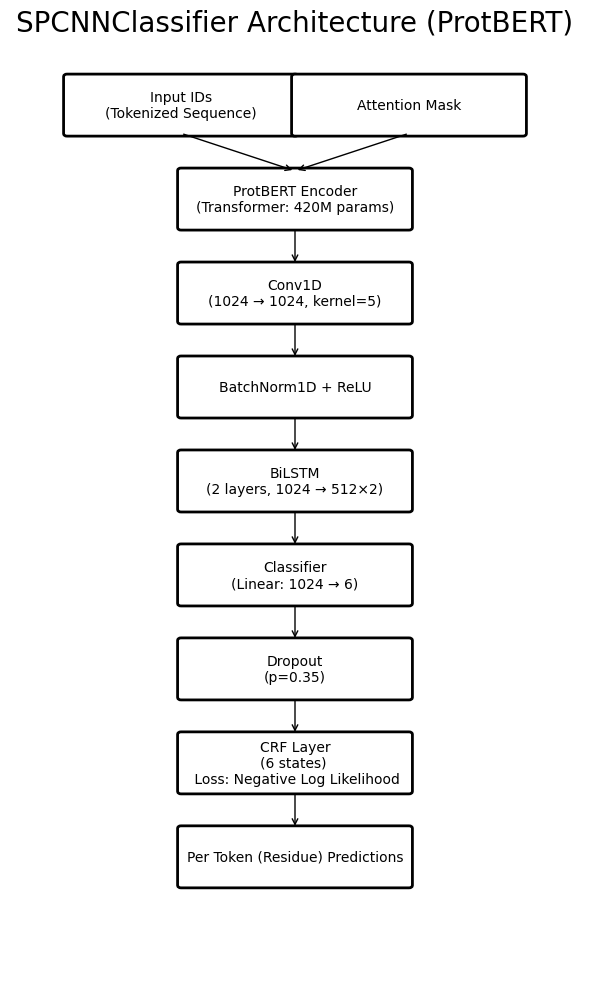

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def draw_vertical_model():
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.axis('off')

    # Define blocks with (x, y)
    blocks = [
        ("Input IDs\n(Tokenized Sequence)", 0.5, 9.0),
        ("Attention Mask", 2.5, 9.0),
        ("ProtBERT Encoder\n(Transformer: 420M params)", 1.5, 8.0),
        ("Conv1D\n(1024 → 1024, kernel=5)", 1.5, 7.0),
        ("BatchNorm1D + ReLU", 1.5, 6.0),
        ("BiLSTM\n(2 layers, 1024 → 512×2)", 1.5, 5.0),
        ("Classifier\n(Linear: 1024 → 6)", 1.5, 4.0),
        ("Dropout\n(p=0.35)", 1.5, 3.0),
        ("CRF Layer\n(6 states) \n Loss: Negative Log Likelihood", 1.5, 2.0),
        ("Per Token (Residue) Predictions", 1.5, 1.0)
    ]

    box_width = 2.0
    box_height = 0.6

    # Draw blocks
    for label, x, y in blocks:
        rect = mpatches.FancyBboxPatch((x, y), box_width, box_height, boxstyle="round,pad=0.03",
                                       edgecolor='black', facecolor='white', linewidth=2)
        ax.add_patch(rect)
        ax.text(x + box_width / 2, y + box_height / 2, label, ha='center', va='center', fontsize=10)

    # Draw arrows
    for i in range(2, len(blocks) - 1):  # skip input IDs and mask arrows
        x1 = blocks[i][1] + box_width / 2
        y1 = blocks[i][2]
        y2 = blocks[i+1][2] + box_height
        ax.annotate('', xy=(x1, y2), xytext=(x1, y1),
                    arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Draw arrows from inputs
    ax.annotate('', xy=(1.5 + box_width/2, 8.6), xytext=(0.5 + box_width/2, 9.0),
                arrowprops=dict(facecolor='black', arrowstyle='->'))
    ax.annotate('', xy=(1.5 + box_width/2, 8.6), xytext=(2.5 + box_width/2, 9.0),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

    plt.title("SPCNNClassifier Architecture (ProtBERT)", fontsize=20)
    plt.ylim(0, 10)
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()

draw_vertical_model()